In [1]:
import requests
from datetime import datetime
import math
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

# Übersicht der Struktur von api-football.com
https://www.api-football.com/documentation-v3
![title](img/api-football-com_overview.png)

In [2]:
# Funktion zum Abrufen von Daten über api-football.com
def fetch_data(endpoint):
    base_url = 'https://v3.football.api-sports.io'
    headers = {'x-rapidapi-key': '9042f6002a1d87dba47a9712a79e63c7'}  # Hier den API-Schlüssel einfügen
    response = requests.get(base_url + endpoint, headers=headers)
    data = response.json()
    return data

In [3]:
# Verbindung zur MongoDB-Datenbank am Azure Server herstellen
client = pymongo.MongoClient(
    host='20.82.185.108:27017', # <-- IP und Port hier einfügen
    serverSelectionTimeoutMS=30000, # 30 Sekunden Timeout
    username="group3",
    password="football",
)

# Datenbank auswählen
db = client['football_stats'] # Datenbankname hier einfügen

In [4]:
db.list_collection_names()

ServerSelectionTimeoutError: 20.82.185.108:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30.0s, Topology Description: <TopologyDescription id: 6630ae36f5245483f5fde020, topology_type: Unknown, servers: [<ServerDescription ('20.82.185.108', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('20.82.185.108:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [8]:
# Funktion zum Einfügen einer Liste von Dokumenten in die MongoDB-Datenbank
def insert_many_to_database(documents, collection_name):
    collection = db[collection_name] # Collection erstellen bzw auswählen
    return collection.insert_many(documents)

In [9]:
# Funktion zum Einfügen eines einzelnen Dokuments in die MongoDB-Datenbank
def insert_one_to_database(document, collection_name):
    collection = db[collection_name] # Collection erstellen bzw auswählen  
    return collection.insert_one(document)

In [10]:
# Funktion zur Extraktion von Daten über die Ligen
def extract_leagues_data():
    leagues_data = fetch_data(f"/leagues")    
    return leagues_data

In [96]:
leagues = extract_leagues_data()

print("Num of leagues:", len(leagues["response"]))
first_response = leagues["response"][0]
# testing to create one league entry
league = first_response["league"]
league["country"] = first_response["country"]["name"]
league["last_season_id"] = first_response["seasons"][-1]["year"]
print(league)
print(type(league)) 

Num of leagues: 1094
{'id': 4, 'name': 'Euro Championship', 'type': 'Cup', 'logo': 'https://media.api-sports.io/football/leagues/4.png', 'country': 'World', 'last_season_id': 2024}
<class 'dict'>


In [ ]:
# Daten der Ligen in die collection "api_football_com_leagues" einfügen
i = 1

for r in leagues["response"]:
    league = r["league"]
    league["country"] = r["country"]["name"]
    league["last_season_id"] = r["seasons"][-1]["year"]
    insert_result = insert_one_to_database(league, "api_football_com_leagues")
    print("entry_number:", i, "inserted_id:", insert_result.inserted_id)  
    i+=1

In [11]:
# collection löschen
#db.api_football_com_leagues.drop()

# Abfrage des ersten Eintrags aus der collection "api_football_com_leagues"
db.api_football_com_leagues.find_one()

{'_id': ObjectId('66242bf174a7545451a67b9a'),
 'id': 4,
 'name': 'Euro Championship',
 'type': 'Cup',
 'logo': 'https://media.api-sports.io/football/leagues/4.png',
 'country': 'World',
 'last_season_id': 2024}

In [12]:
# Abfrage der Bundesliga in AT von der MongoDB
for x in db.api_football_com_leagues.find({"name": "Bundesliga", "country": "Austria"}):
  print(x) 

{'_id': ObjectId('66242c2974a7545451a67bea'), 'id': 218, 'name': 'Bundesliga', 'type': 'League', 'logo': 'https://media.api-sports.io/football/leagues/218.png', 'country': 'Austria', 'last_season_id': 2023}


In [12]:
# Funktion zur Extraktion der Daten aller Teams, einer bestimmten Saison, einer bestimmten Liga
def extract_teams_league_season_data(league_id, season_id):
    teams_league_season_data = fetch_data(f"/teams?league=" + str(league_id) + "&season=" + str(season_id))    
    return teams_league_season_data

In [18]:
current_austrian_bundesliga_teams = extract_teams_league_season_data(218, 2023)

print(current_austrian_bundesliga_teams["response"][0])

{'team': {'id': 571, 'name': 'Red Bull Salzburg', 'code': 'SAL', 'country': 'Austria', 'founded': 1933, 'national': False, 'logo': 'https://media.api-sports.io/football/teams/571.png'}, 'venue': {'id': 148, 'name': 'Red Bull Arena', 'address': 'Stadionstrasse 2/3', 'city': 'Wals-Siezenheim', 'capacity': 31895, 'surface': 'grass', 'image': 'https://media.api-sports.io/football/venues/148.png'}}


In [19]:
current_austrian_bundesliga_teams = current_austrian_bundesliga_teams["response"]

for current_austrian_bundesliga_team in current_austrian_bundesliga_teams:
    current_austrian_bundesliga_team["league_id"] = 218
    current_austrian_bundesliga_team["season_id"] = 2023
    
print(current_austrian_bundesliga_teams[0])

{'team': {'id': 571, 'name': 'Red Bull Salzburg', 'code': 'SAL', 'country': 'Austria', 'founded': 1933, 'national': False, 'logo': 'https://media.api-sports.io/football/teams/571.png'}, 'venue': {'id': 148, 'name': 'Red Bull Arena', 'address': 'Stadionstrasse 2/3', 'city': 'Wals-Siezenheim', 'capacity': 31895, 'surface': 'grass', 'image': 'https://media.api-sports.io/football/venues/148.png'}, 'league_id': 218, 'season_id': 2023}


In [23]:
for t in current_austrian_bundesliga_teams:
    insert_result = insert_one_to_database(t, "api_football_com_leagues_seasons_teams")
    team = t["team"]
    print("team_id:", team["id"], "| team_name:", team["name"], "| inserted_id:", insert_result.inserted_id)

team_id: 571 | team_name: Red Bull Salzburg | inserted_id: 66258d8b8fec5c65f04fe91a
team_id: 601 | team_name: Austria Vienna | inserted_id: 66258d8b8fec5c65f04fe91b
team_id: 618 | team_name: SCR Altach | inserted_id: 66258d8b8fec5c65f04fe91c
team_id: 637 | team_name: Sturm Graz | inserted_id: 66258d8b8fec5c65f04fe91d
team_id: 781 | team_name: Rapid Vienna | inserted_id: 66258d8b8fec5c65f04fe91e
team_id: 1025 | team_name: Wolfsberger AC | inserted_id: 66258d8b8fec5c65f04fe91f
team_id: 1026 | team_name: Lask Linz | inserted_id: 66258d8b8fec5c65f04fe920
team_id: 1072 | team_name: TSV Hartberg | inserted_id: 66258d8b8fec5c65f04fe921
team_id: 1394 | team_name: FC BW Linz | inserted_id: 66258d8b8fec5c65f04fe922
team_id: 1398 | team_name: WSG Wattens | inserted_id: 66258d8c8fec5c65f04fe923
team_id: 1399 | team_name: Austria Lustenau | inserted_id: 66258d8c8fec5c65f04fe924
team_id: 1405 | team_name: Austria Klagenfurt | inserted_id: 66258d8c8fec5c65f04fe925


In [26]:
# Abfrage der Teams der Bundesliga in AT von der MongoDB
for x in db.api_football_com_leagues_seasons_teams.find({"league_id": 218, "season_id": 2023}):
  print(x) 

{'_id': ObjectId('66258d8b8fec5c65f04fe91a'), 'team': {'id': 571, 'name': 'Red Bull Salzburg', 'code': 'SAL', 'country': 'Austria', 'founded': 1933, 'national': False, 'logo': 'https://media.api-sports.io/football/teams/571.png'}, 'venue': {'id': 148, 'name': 'Red Bull Arena', 'address': 'Stadionstrasse 2/3', 'city': 'Wals-Siezenheim', 'capacity': 31895, 'surface': 'grass', 'image': 'https://media.api-sports.io/football/venues/148.png'}, 'league_id': 218, 'season_id': 2023}
{'_id': ObjectId('66258d8b8fec5c65f04fe91b'), 'team': {'id': 601, 'name': 'Austria Vienna', 'code': 'AUS', 'country': 'Austria', 'founded': 1911, 'national': False, 'logo': 'https://media.api-sports.io/football/teams/601.png'}, 'venue': {'id': 136, 'name': 'Generali Arena', 'address': 'Fischhofgasse 14', 'city': 'Wien', 'capacity': 18944, 'surface': 'grass', 'image': 'https://media.api-sports.io/football/venues/136.png'}, 'league_id': 218, 'season_id': 2023}
{'_id': ObjectId('66258d8b8fec5c65f04fe91c'), 'team': {'id

In [13]:
# Funktion zur Extraktion von Daten über ein bestimmtes Team, einer bestimmten Saison, einer bestimmten Liga
def extract_team_data(season_id, team_id, league_id):
    team_data = fetch_data(f"/teams/statistics?season=" + str(season_id) + "&team=" + str(team_id) + "&league=" + str(league_id))
    #top_scorers = scorers_data["scorers"][:num_players]  # Die ersten num_players Top-Torschützen
    return team_data

In [14]:
# Beispiel 
team = extract_team_data(2023, 781, 218)
print(team)

{'get': 'teams/statistics', 'parameters': {'season': '2023', 'team': '781', 'league': '218'}, 'errors': [], 'results': 11, 'paging': {'current': 1, 'total': 1}, 'response': {'league': {'id': 218, 'name': 'Bundesliga', 'country': 'Austria', 'logo': 'https://media.api-sports.io/football/leagues/218.png', 'flag': 'https://media.api-sports.io/flags/at.svg', 'season': 2023}, 'team': {'id': 781, 'name': 'Rapid Vienna', 'logo': 'https://media.api-sports.io/football/teams/781.png'}, 'form': 'DWLWDLDDDWLDWLWWLWDWDDDWDDLLL', 'fixtures': {'played': {'home': 14, 'away': 15, 'total': 29}, 'wins': {'home': 3, 'away': 6, 'total': 9}, 'draws': {'home': 7, 'away': 5, 'total': 12}, 'loses': {'home': 4, 'away': 4, 'total': 8}}, 'goals': {'for': {'total': {'home': 21, 'away': 23, 'total': 44}, 'average': {'home': '1.5', 'away': '1.5', 'total': '1.5'}, 'minute': {'0-15': {'total': 8, 'percentage': '18.60%'}, '16-30': {'total': 8, 'percentage': '18.60%'}, '31-45': {'total': 6, 'percentage': '13.95%'}, '46-6

In [15]:
# Funktion zur Extraktion von Daten der Spieler eines Teams
def extract_squad_data(team_id):
    squad_data = fetch_data(f"/players/squads?team=" + str(team_id))
    #top_scorers = scorers_data["scorers"][:num_players]  # Die ersten num_players Top-Torschützen
    return squad_data

In [16]:
squad = extract_squad_data(781)

In [17]:
#print(type(squad))
#print(type(squad["response"]))
#print(len(squad["response"]))

rapid_vienna_squad = squad["response"][0]
print(type(rapid_vienna_squad))
print(rapid_vienna_squad)

<class 'dict'>
{'team': {'id': 781, 'name': 'Rapid Vienna', 'logo': 'https://media.api-sports.io/football/teams/781.png'}, 'players': [{'id': 78400, 'name': 'B. Unger', 'age': 24, 'number': 21, 'position': 'Goalkeeper', 'photo': 'https://media.api-sports.io/football/players/78400.png'}, {'id': 1710, 'name': 'P. Gartler', 'age': 26, 'number': 25, 'position': 'Goalkeeper', 'photo': 'https://media.api-sports.io/football/players/1710.png'}, {'id': 169346, 'name': 'N. Hedl', 'age': 22, 'number': 45, 'position': 'Goalkeeper', 'photo': 'https://media.api-sports.io/football/players/169346.png'}, {'id': 302866, 'name': 'L. Orgler', 'age': 19, 'number': 50, 'position': 'Goalkeeper', 'photo': 'https://media.api-sports.io/football/players/302866.png'}, {'id': 134756, 'name': 'N. Kasanwirjo', 'age': 21, 'number': 6, 'position': 'Defender', 'photo': 'https://media.api-sports.io/football/players/134756.png'}, {'id': 19043, 'name': 'T. Kongolo', 'age': 29, 'number': 15, 'position': 'Defender', 'photo'

In [18]:
# Create DataFrame
df = pd.DataFrame(squad["response"][0]["players"])

# Print DataFrame
print(df)

from statistics import mean

# Mittelwert des Alters der Spieler ausgeben
print("average age:", mean(df["age"]))

        id            name  age  number    position  \
0    78400        B. Unger   24    21.0  Goalkeeper   
1     1710      P. Gartler   26    25.0  Goalkeeper   
2   169346         N. Hedl   22    45.0  Goalkeeper   
3   302866       L. Orgler   19    50.0  Goalkeeper   
4   134756   N. Kasanwirjo   21     6.0    Defender   
5    19043      T. Kongolo   29    15.0    Defender   
6     7554    M. Sollbauer   33    19.0    Defender   
7     1718      M. Hofmann   30    20.0    Defender   
8    66728         J. Auer   23    23.0    Defender   
9   169335     M. Moormann   22    26.0    Defender   
10  288206     L. Querfeld   20    43.0    Defender   
11   46160    N. Cvetković   27    55.0    Defender   
12  334028       D. Vincze   19     NaN    Defender   
13    7152   R. Kerschbaum   29     5.0  Midfielder   
14    7072        L. Grgić   28     8.0  Midfielder   
15     956       T. Schick   33    13.0  Midfielder   
16  176022        M. Seidl   22    18.0  Midfielder   
17  328226

In [ ]:
# Abfrage der Teams der Bundesliga in AT von der MongoDB und jeweils der zugehörigen Mannschaften, um diese auch in die MongoDB zu speichern
for x in db.api_football_com_leagues_seasons_teams.find({"league_id": 218, "season_id": 2023}):
    team_id = x["team"]["id"]
    squad = extract_squad_data(team_id)
    insert_result = insert_one_to_database(squad["response"][0], "api_football_com_teams_squads")
    print("team_name:", x["team"]["name"], "| inserted_id:", insert_result.inserted_id) 

In [44]:
# Abfrage der Teams aus der Collection der Mannschaften von der MongoDB
for x in db.api_football_com_teams_squads.find():
  team = x["team"]
  print("team_id:", team["id"], "team_name:", team["name"])

team_id: 33 team_name: Manchester United
team_id: 571 team_name: Red Bull Salzburg
team_id: 601 team_name: Austria Vienna
team_id: 618 team_name: SCR Altach
team_id: 637 team_name: Sturm Graz
team_id: 781 team_name: Rapid Vienna
team_id: 1025 team_name: Wolfsberger AC
team_id: 1026 team_name: Lask Linz
team_id: 1072 team_name: TSV Hartberg
team_id: 1394 team_name: FC BW Linz
team_id: 1398 team_name: WSG Wattens
team_id: 1399 team_name: Austria Lustenau
team_id: 1405 team_name: Austria Klagenfurt


In [21]:
# Funktion zur Extraktion von Daten über einen bestimmten Spieler in einer bestimmten Saison
def extract_player_data(player_id, season_id):
    player_data = fetch_data(f"/players?id=" + str(player_id) + "&season=" + str(season_id))    
    return player_data

In [22]:
player = extract_player_data(7073, 2023)
print(player)

{'get': 'players', 'parameters': {'id': '7073', 'season': '2023'}, 'errors': [], 'results': 1, 'paging': {'current': 1, 'total': 1}, 'response': [{'player': {'id': 7073, 'name': 'M. Grüll', 'firstname': 'Marco', 'lastname': 'Grüll', 'age': 26, 'birth': {'date': '1998-07-06', 'place': 'Schwarzach im Pongau', 'country': 'Austria'}, 'nationality': 'Austria', 'height': '182 cm', 'weight': '74 kg', 'injured': False, 'photo': 'https://media.api-sports.io/football/players/7073.png'}, 'statistics': [{'team': {'id': 781, 'name': 'Rapid Vienna', 'logo': 'https://media.api-sports.io/football/teams/781.png'}, 'league': {'id': 218, 'name': 'Bundesliga', 'country': 'Austria', 'logo': 'https://media.api-sports.io/football/leagues/218.png', 'flag': 'https://media.api-sports.io/flags/at.svg', 'season': 2023}, 'games': {'appearences': 25, 'lineups': 22, 'minutes': 1951, 'number': None, 'position': 'Midfielder', 'rating': '7.600000', 'captain': False}, 'substitutes': {'in': 3, 'out': 9, 'bench': 3}, 'sho

In [24]:
# Funktion zur Extraktion von Daten über den Tabellenstand einer bestimmten Liga, einer bestimmten Saison, eines bestimmten Teams
def extract_standing_data(league_id, season_id, team_id):
    standing_data = fetch_data(f"/standings?league=" + str(league_id) + "&season=" + str(season_id) + "&team=" + str(team_id))
    #top_scorers = scorers_data["scorers"][:num_players]  # Die ersten num_players Top-Torschützen
    return standing_data

In [25]:
standing = extract_standing_data(218, 2023, 781)
print(standing)

{'get': 'standings', 'parameters': {'league': '218', 'season': '2023', 'team': '781'}, 'errors': [], 'results': 1, 'paging': {'current': 1, 'total': 1}, 'response': [{'league': {'id': 218, 'name': 'Bundesliga', 'country': 'Austria', 'logo': 'https://media.api-sports.io/football/leagues/218.png', 'flag': 'https://media.api-sports.io/flags/at.svg', 'season': 2023, 'standings': [[{'rank': 4, 'team': {'id': 781, 'name': 'Rapid Vienna', 'logo': 'https://media.api-sports.io/football/teams/781.png'}, 'points': 22, 'goalsDiff': 17, 'group': 'Bundesliga: Championship Round', 'form': 'LLDDW', 'status': 'same', 'description': 'UEFA Europa League Qualifiers', 'all': {'played': 28, 'win': 9, 'draw': 12, 'lose': 7, 'goals': {'for': 44, 'against': 27}}, 'home': {'played': 3, 'win': 0, 'draw': 2, 'lose': 1, 'goals': {'for': 2, 'against': 4}}, 'away': {'played': 3, 'win': 1, 'draw': 1, 'lose': 1, 'goals': {'for': 4, 'against': 2}}, 'update': '2024-04-26T00:00:00+00:00'}], [{'rank': 6, 'team': {'id': 78

In [27]:
# Funktion zur Extraktion von Daten über den Tabellenstand einer bestimmten Liga, einer bestimmten Saison
def extract_standings_data(league_id, season_id):
    standings_data = fetch_data(f"/standings?league=" + str(league_id) + "&season=" + str(season_id))   
    return standings_data

In [ ]:
standings = extract_standings_data(218, 2023)

print(type(standings["response"]))
print(len(standings["response"]))
print(type(standings["response"][0]))
print(standings["response"][0])

austrian_bundesliga_current_standings = standings["response"][0]

insert_result = insert_one_to_database(austrian_bundesliga_current_standings, "api_football_com_leagues_seasons_standings")
print("inserted_id:", insert_result.inserted_id) 

In [ ]:
db.api_football_com_leagues_seasons_standings.find_one()

In [30]:
austrian_bundesliga_team_ids = []
austrian_bundesliga_team_names = []

for x in db.api_football_com_leagues_seasons_teams.find({"league_id": 218, "season_id": 2023}):
    team_id = x["team"]["id"]
    austrian_bundesliga_team_ids.append(team_id)
    team_name = x["team"]["name"]
    austrian_bundesliga_team_names.append(team_name)

austrian_bundesliga_teams_data = {
    "team_id" : austrian_bundesliga_team_ids,
    "team_name" : austrian_bundesliga_team_names    
}

austrian_bundesliga_teams = pd.DataFrame(austrian_bundesliga_teams_data)

print(austrian_bundesliga_teams)

    team_id           team_name
0       571   Red Bull Salzburg
1       601      Austria Vienna
2       618          SCR Altach
3       637          Sturm Graz
4       781        Rapid Vienna
5      1025      Wolfsberger AC
6      1026           Lask Linz
7      1072        TSV Hartberg
8      1394          FC BW Linz
9      1398         WSG Wattens
10     1399    Austria Lustenau
11     1405  Austria Klagenfurt


In [31]:
# map_reduce() is deprecated and not supported by the latest version of pymongo library anymore
# instead the aggregate() method with an aggregation pipeline should be used

pipeline = [
    {"$match": { "team.id" :{"$in":austrian_bundesliga_team_ids}} },    
    {"$unwind": "$players"},    
    {"$group": {"_id": "$team.id", "average_player_age": {"$avg": "$players.age"}}}
]

# Create DataFrame
avg_player_age_per_team = pd.DataFrame(db.api_football_com_teams_squads.aggregate(pipeline))
# Print DataFrame
print(avg_player_age_per_team)

     _id  average_player_age
0    571           21.903226
1    618           25.214286
2    601           24.107143
3   1025           24.296296
4   1026           25.310345
5    637           22.133333
6    781           23.633333
7   1394           25.115385
8   1398           23.629630
9   1405           24.925926
10  1072           23.687500
11  1399           23.777778


In [36]:
# Get points of Team Rapid Vienna
for s in db.api_football_com_leagues_seasons_standings.find_one()["league"]["standings"]:
    for g in s:
        if(g["team"]["id"]==781):
            print(g["group"], "- Points: ", g["points"])    

Bundesliga: Championship Round - Points:  22
Bundesliga: Regular Season - Points:  33


https://www.bundesliga.at/de/spielplan/

![title](img/AustrianBundesligaRoundsOverview.png)
![title](img/AustrianBundesligaGroupsOverview.png)
![title](img/AustrianBundesligaRegularSeasonOverview.png)

In [30]:
# There are values of different groups of austrian Bundesliga!
# 1. Regular Season
# 2. Relegation Round OR Championship Round
# Get only points of second phase - therefore use a match stage in the aggregation pipeline
pipeline = [
    {"$match": { "league.id" : 218, "league.season" : 2023} },    
    {"$unwind": "$league.standings"},
    {"$unwind": "$league.standings"},      
    {"$match": {"$or" : [{"league.standings.group" : "Bundesliga: Relegation Round"},{"league.standings.group" : "Bundesliga: Championship Round"}]}}, 
    {"$group": {"_id": "$league.standings.team.id", "points": {"$max": "$league.standings.points"}}}
]

league_points_per_team = pd.DataFrame(db.api_football_com_leagues_seasons_standings.aggregate(pipeline))
print(league_points_per_team)

     _id  points
0    601      25
1   1025      19
2   1394      13
3   1399       8
4   1026      24
5    781      22
6   1072      21
7   1405      19
8    637      35
9    618      16
10   571      35
11  1398      15


In [31]:
avg_player_age_and_league_points_per_team = pd.merge(avg_player_age_per_team, league_points_per_team)
avg_player_age_and_league_points_per_team = pd.merge(austrian_bundesliga_teams, avg_player_age_and_league_points_per_team, how='left', left_on='team_id', right_on='_id')
avg_player_age_and_league_points_per_team = avg_player_age_and_league_points_per_team.sort_values('points')
print(avg_player_age_and_league_points_per_team[["team_id", "team_name", "average_player_age", "points"]])

    team_id           team_name  average_player_age  points
10     1399    Austria Lustenau           23.777778       8
8      1394          FC BW Linz           25.115385      13
9      1398         WSG Wattens           23.629630      15
2       618          SCR Altach           25.214286      16
5      1025      Wolfsberger AC           24.296296      19
11     1405  Austria Klagenfurt           24.925926      19
7      1072        TSV Hartberg           23.687500      21
4       781        Rapid Vienna           23.633333      22
6      1026           Lask Linz           25.310345      24
1       601      Austria Vienna           24.107143      25
0       571   Red Bull Salzburg           21.903226      35
3       637          Sturm Graz           22.133333      35


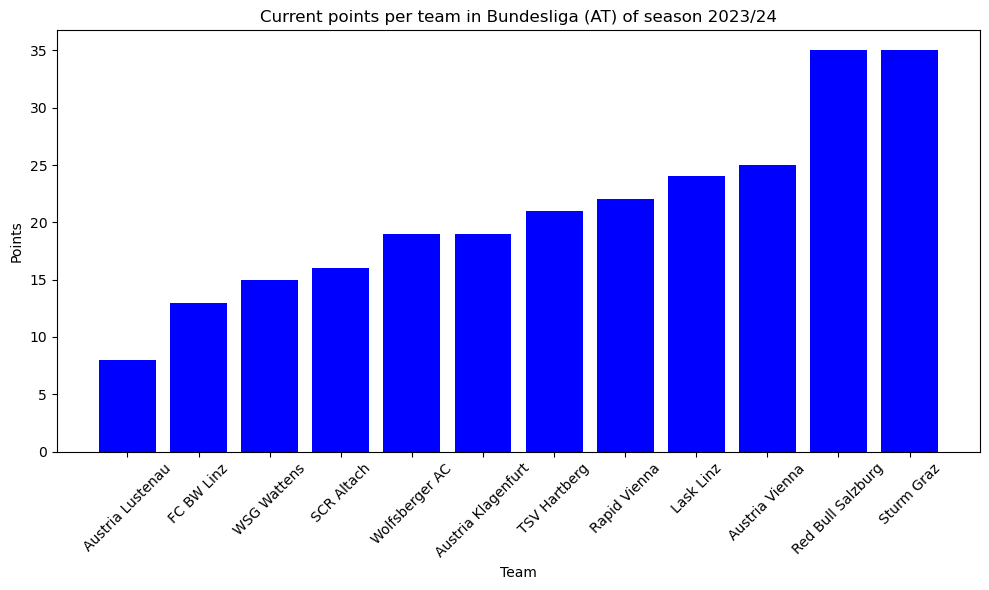

In [32]:
# Visualisierung der Daten
plt.figure(figsize=(10, 6))
x = avg_player_age_and_league_points_per_team["team_name"]
y = avg_player_age_and_league_points_per_team["points"]

plt.bar(x, y, color='blue')
plt.xlabel('Team')
plt.ylabel('Points')
plt.title('Current points per team in Bundesliga (AT) of season 2023/24')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

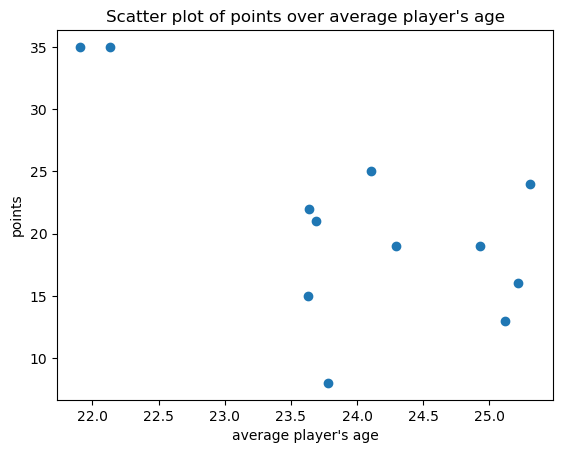

In [35]:
x = avg_player_age_and_league_points_per_team["average_player_age"]
y = avg_player_age_and_league_points_per_team["points"]

# plot
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xlabel('average player\'s age')
ax.set_ylabel('points')
ax.set_title('Scatter plot of points over average player\'s age')

plt.show()

Auffallend ist, dass die beiden Teams, die mit Abstand die meisten Punkten haben, auch jene sind, die das geringste mittlere Alter der Mannschaft aufweisen.